## import data and add columns

In [1]:
import numpy as np
# from astropy.stats import binom_conf_interval
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pandas as pd
from astropy.stats import binom_conf_interval
from pandasql import sqldf

df = pd.read_csv('labeled_residents_graph.csv.gz')

In [2]:
## drop 0 weight edges (these appear because of the max 28 day cutoff)
#df = df[df['confidence_score_28_day']>0.0]
df['isolation_start_1'] = pd.to_datetime(df['isolation_start_1'])
df['isolation_start_2'] = pd.to_datetime(df['isolation_start_2'])
df['isolation_diff_hours'] = (df['isolation_start_2'] - df['isolation_start_1'])/pd.Timedelta('1 hour')
df

id_1    id_2  in_isolation_1  in_isolation_2 home_hall_1  \
0            75      25               1               0    chadhall   
1            75      38               1               0    chadhall   
2            75      41               1               0    chadhall   
3            75      52               1               0    chadhall   
4            75      61               1               0    chadhall   
...         ...     ...             ...             ...         ...   
1172629  165199  165528               1               0       witte   
1172630  165199  165740               1               0       witte   
1172631  165199  166612               1               0       witte   
1172632  165199  170895               1               0       witte   
1172633  165199  172001               1               0       witte   

        home_hall_2   isolation_start_1 isolation_start_2  \
0          lizwater 2021-02-10 12:00:00               NaT   
1         lakeshore 2021-02-10 12:00:00               NaT   
2               ogg 2021-02-10 12:00:00               NaT   
3             par35 2021-02-10 12:00:00               NaT   
4               ogg 2021-02-10 12:00:00               NaT   
...             ...                 ...               ...   
1172629    chadhall 2021-02-06 15:45:00               NaT   
1172630       witte 2021-02-06 15:45:00               NaT   
1172631         ogg 2021-02-06 15:45:00               NaT   
1172632   susbdavis 2021-02-06 15:45:00               NaT   
1172633         ogg 2021-02-06 15:45:00               NaT   

         total_confidence_score  total_epoch_count  confidence_score_7_day  \
0                          0.12                  1                    0.00   
1                          0.03                  1                    0.00   
2                          0.33                  3                    0.00   
3                          0.96                  6                    0.00   
4                          0.12                  2                    0.00   
...                         ...                ...                     ...   
1172629                    0.30                  8                    0.03   
1172630                    0.07                  1                    0.00   
1172631                    0.03                  1                    0.00   
1172632                    0.28                  2                    0.00   
1172633                    0.02                  1                    0.00   

         confidence_score_14_day  confidence_score_21_day  \
0                           0.00                     0.00   
1                           0.03                     0.03   
2                           0.00                     0.00   
3                           0.00                     0.00   
4                           0.00                     0.00   
...                          ...                      ...   
1172629                     0.03                     0.03   
1172630                     0.00                     0.00   
1172631                     0.03                     0.03   
1172632                     0.00                     0.00   
1172633                     0.00                     0.00   

         confidence_score_28_day  epoch_count_7_day  epoch_count_14_day  \
0                           0.00                  0                   0   
1                           0.03                  0                   1   
2                           0.00                  0                   0   
3                           0.00                  0                   0   
4                           0.00                  0                   0   
...                          ...                ...                 ...   
1172629                     0.03                  1                   1   
1172630                     0.00                  0                   0   
1172631                     0.03                  0                   1   
11726

In [3]:
some_positive_ids = np.random.choice(df[df['in_isolation_2']==1]['id_2'].unique(), 5)
some_negative_ids = np.random.choice(df[df['in_isolation_2']==0]['id_2'].unique(), 5)
all_ids = df['id_2'].unique()
len(all_ids)

6451

In [4]:
#number of total positive cases:
pos_times = df[df['in_isolation_1']==1][['id_1','isolation_start_1']].drop_duplicates().reset_index(drop=True)
total_pos = 0
total_subjects = 0

for i, t_i in enumerate(pos_times['isolation_start_1']):
    ## count number of positives in next 7 days
    for t_j in pos_times['isolation_start_1']:
        if t_j > t_i and t_j <= t_i + pd.Timedelta('7 day'):
            total_pos += 1
    total_subjects += (6461-i+1)

# this gives the ppv of choosing a subject at random
print(total_pos)
print(total_subjects)
print(total_pos/total_subjects)

17397
2200625
0.007905481397330305


In [5]:
#number of total positive cases:
pos_times = df[df['in_isolation_1']==1][['id_1','isolation_start_1']].drop_duplicates().reset_index(drop=True)
total_pos = 0
total_subjects = 0

for i, t_i in enumerate(pos_times['isolation_start_1']):
    ## count number of positives in next 7 days
    for t_j in pos_times['isolation_start_1']:
        if t_j > t_i and t_j <= t_i + pd.Timedelta('28 day'):
            total_pos += 1
    total_subjects += (6461-i+1)

# this gives the ppv of choosing a subject at random
print(total_pos)
print(total_subjects)
print(total_pos/total_subjects)

46859
2200625
0.021293496165861972


In [6]:
import datetime as dt
from dateutil import parser

def hours_since_epoch(t):
    try:
        return (t - start_date).days*24 + int((t-start_date).seconds/3600)
    except:
        return np.NaN 

start_date = parser.parse('2021-01-28')
end_date = parser.parse('2021-05-7')

score_vec_length = hours_since_epoch(end_date)
score_matrix = np.zeros((len(all_ids), score_vec_length))

isolation_start_list = []
user_vec = []

for i, user in enumerate(all_ids):
    score_vec = np.zeros((score_vec_length))
    for index, row in df[df['id_2']==user].sort_values(by='isolation_start_1').iterrows():
        start_ind = hours_since_epoch(row['isolation_start_1'])
        end_ind = min(hours_since_epoch(row['isolation_start_1'] + dt.timedelta(days=7) ), score_vec_length-1)   
        score_vec[start_ind:end_ind] = score_vec[start_ind:end_ind] + row['confidence_score_7_day']
        isolation_start_2 = row['isolation_start_2']

    score_matrix[i,:] = score_vec
    isolation_start_list.append(isolation_start_2)
    user_vec.append(user)

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


<Figure size 1152x576 with 0 Axes>

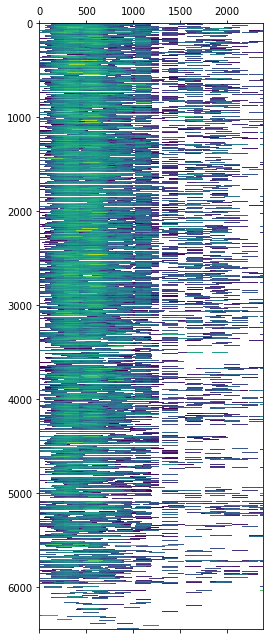

In [7]:
plt.figure(num=None, figsize=(16, 8), facecolor='w', edgecolor='k')
plt.matshow(np.log(score_matrix))

#print(np.shape(score_matrix))
#subjects, hours = np.shape(score_matrix)
#print(isolation_start_list)

In [8]:
gamma_vec = [i for i in range(1,20)] + [10*(i)+20 for i in range(18)]
print(gamma_vec)

results = []
tau_p = 7*24
for gamma in gamma_vec:
    print(gamma)
    predicted_positive = 0
    predicted_negative = 0
    true_positive = 0
    true_negative = 0
    for user, row in enumerate(score_matrix):
        predicted = False
        for hour, score in enumerate(row):
            if score >= gamma and predicted == False:
                predicted_hour = hour
                predicted = True
        isolation_start_hour = hours_since_epoch(isolation_start_list[user])
        # note if already positive, don't count in study
        if np.isnan(isolation_start_hour) or isolation_start_hour >= predicted_hour:
            if predicted == True:        
                predicted_positive += 1
                if ~np.isnan(isolation_start_hour) and isolation_start_hour <= predicted_hour + tau_p:
                    true_positive += 1
            if predicted == False:
                predicted_negative += 1
                if np.isnan(isolation_start_hour) or isolation_start_hour > predicted_hour + tau_p:
                    true_negative += 1
    results.append((predicted_positive, true_positive, predicted_negative,true_negative))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [9]:
gamma_vec = [i for i in range(1,20)] + [10*(i)+20 for i in range(18)]
print(gamma_vec)

results_28 = []
tau_p = 28*24
for gamma in gamma_vec:
    print(gamma)
    predicted_positive = 0
    predicted_negative = 0
    true_positive = 0
    true_negative = 0
    for user, row in enumerate(score_matrix):
        predicted = False
        for hour, score in enumerate(row):
            if score >= gamma and predicted == False:
                predicted_hour = hour
                predicted = True
        isolation_start_hour = hours_since_epoch(isolation_start_list[user])
        # note if already positive, don't count in study
        if np.isnan(isolation_start_hour) or isolation_start_hour >= predicted_hour:
            if predicted == True:        
                predicted_positive += 1
                if ~np.isnan(isolation_start_hour) and isolation_start_hour <= predicted_hour + tau_p:
                    true_positive += 1
            if predicted == False:
                predicted_negative += 1
                if np.isnan(isolation_start_hour) or isolation_start_hour > predicted_hour + tau_p:
                    true_negative += 1
    results_28.append((predicted_positive, true_positive, predicted_negative,true_negative))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


100


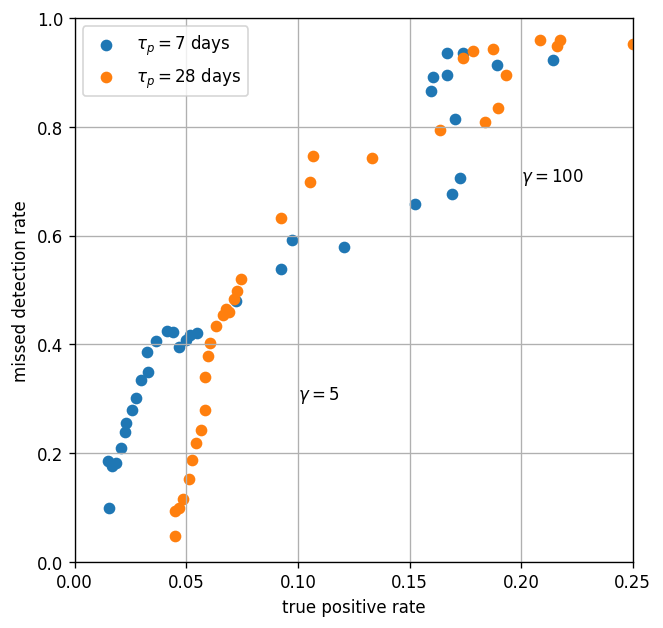

In [10]:
plt.figure(num=None, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')

true_positive_rate = [i[1]/i[0] if i[0] > 0  else 0 for i in results[1:-2]]
true_negative_rate = [i[3]/i[2] if i[3] > 0  else 0 for i in results[1:-2]]
missed_detection_rate = [((i[2]-i[3])) /(i[1]+(i[2]-i[3]))   for i in results[1:-2]]

true_positive_rate_28 = [i[1]/i[0] if i[0] > 0  else 0 for i in results_28[1:-2]]
true_negative_rate_28 = [i[3]/i[2] if i[3] > 0  else 0 for i in results_28[1:-2]]
missed_detection_rate_28 = [((i[2]-i[3])) /(i[1]+(i[2]-i[3]))   for i in results_28[1:-2]]

plt.scatter(true_positive_rate, missed_detection_rate)
plt.scatter(true_positive_rate_28, missed_detection_rate_28)
print(gamma_vec[-10])
plt.xlabel('true positive rate')
plt.ylabel('missed detection rate')
plt.grid()
plt.xlim(0, 0.25)
plt.ylim(0, 1)
plt.legend([r'$\tau_p = 7$ days', r'$\tau_p = 28$ days'])
plt.text(.1,.3, r'$\gamma = 5$')
plt.text(.2,.7, r'$\gamma = 100$')
plt.savefig('exposure_score_roc.pdf', format='pdf')

In [11]:
## append cummulative score to df

score_df = pd.DataFrame(score_matrix)
columns = score_df.columns
score_df['id'] = pd.Series(user_vec)

long_form_score_df = pd.DataFrame(columns = ["id", "exposure_score", "hour"]) 
print(long_form_score_df)

for column in columns:
    temp_df = pd.DataFrame()
    temp_df = score_df[['id', column]]
    temp_df.rename(columns = {'id': 'id', column:'exposure_score'}, inplace =True )
    temp_df['hour'] = int(str(column))
    long_form_score_df = long_form_score_df.append(temp_df, ignore_index=True)
    print(column, end = ' ')
#rankings_pd.rename(columns = {'test':'TEST', 'odi':'ODI',
#                              't20':'T20'}, inplace = True)


#full_new_df = df.merge(score_df, how='left', on=None, left_on='id_2', right_on='id')
#full_new_df
#left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None

Empty DataFrame
Columns: [id, exposure_score, hour]
Index: []
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 29

1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 

In [12]:
df['hour'] = df['isolation_start_1'].apply(hours_since_epoch)


In [13]:
df

id_1    id_2  in_isolation_1  in_isolation_2 home_hall_1  \
0            75      25               1               0    chadhall   
1            75      38               1               0    chadhall   
2            75      41               1               0    chadhall   
3            75      52               1               0    chadhall   
4            75      61               1               0    chadhall   
...         ...     ...             ...             ...         ...   
1172629  165199  165528               1               0       witte   
1172630  165199  165740               1               0       witte   
1172631  165199  166612               1               0       witte   
1172632  165199  170895               1               0       witte   
1172633  165199  172001               1               0       witte   

        home_hall_2   isolation_start_1 isolation_start_2  \
0          lizwater 2021-02-10 12:00:00               NaT   
1         lakeshore 2021-02-10 12:00:00               NaT   
2               ogg 2021-02-10 12:00:00               NaT   
3             par35 2021-02-10 12:00:00               NaT   
4               ogg 2021-02-10 12:00:00               NaT   
...             ...                 ...               ...   
1172629    chadhall 2021-02-06 15:45:00               NaT   
1172630       witte 2021-02-06 15:45:00               NaT   
1172631         ogg 2021-02-06 15:45:00               NaT   
1172632   susbdavis 2021-02-06 15:45:00               NaT   
1172633         ogg 2021-02-06 15:45:00               NaT   

         total_confidence_score  total_epoch_count  confidence_score_7_day  \
0                          0.12                  1                    0.00   
1                          0.03                  1                    0.00   
2                          0.33                  3                    0.00   
3                          0.96                  6                    0.00   
4                          0.12                  2                    0.00   
...                         ...                ...                     ...   
1172629                    0.30                  8                    0.03   
1172630                    0.07                  1                    0.00   
1172631                    0.03                  1                    0.00   
1172632                    0.28                  2                    0.00   
1172633                    0.02                  1                    0.00   

         confidence_score_14_day  confidence_score_21_day  \
0                           0.00                     0.00   
1                           0.03                     0.03   
2                           0.00                     0.00   
3                           0.00                     0.00   
4                           0.00                     0.00   
...                          ...                      ...   
1172629                     0.03                     0.03   
1172630                     0.00                     0.00   
1172631                     0.03                     0.03   
1172632                     0.00                     0.00   
1172633                     0.00                     0.00   

         confidence_score_28_day  epoch_count_7_day  epoch_count_14_day  \
0                           0.00                  0                   0   
1                           0.03                  0                   1   
2                           0.00                  0                   0   
3                           0.00                  0                   0   
4                           0.00                  0                   0   
...                          ...                ...                 ...   
1172629                     0.03                  1                   1   
1172630                     0.00                  0                   0   
1172631                     0.03                  0                   1   
11726

In [14]:
full_new_df = df.merge(long_form_score_df, how='left', left_on=['id_2','hour'] , right_on=['id', 'hour'])


In [15]:
full_new_df

id_1    id_2  in_isolation_1  in_isolation_2 home_hall_1  \
0            75      25               1               0    chadhall   
1            75      38               1               0    chadhall   
2            75      41               1               0    chadhall   
3            75      52               1               0    chadhall   
4            75      61               1               0    chadhall   
...         ...     ...             ...             ...         ...   
1172629  165199  165528               1               0       witte   
1172630  165199  165740               1               0       witte   
1172631  165199  166612               1               0       witte   
1172632  165199  170895               1               0       witte   
1172633  165199  172001               1               0       witte   

        home_hall_2   isolation_start_1 isolation_start_2  \
0          lizwater 2021-02-10 12:00:00               NaT   
1         lakeshore 2021-02-10 12:00:00               NaT   
2               ogg 2021-02-10 12:00:00               NaT   
3             par35 2021-02-10 12:00:00               NaT   
4               ogg 2021-02-10 12:00:00               NaT   
...             ...                 ...               ...   
1172629    chadhall 2021-02-06 15:45:00               NaT   
1172630       witte 2021-02-06 15:45:00               NaT   
1172631         ogg 2021-02-06 15:45:00               NaT   
1172632   susbdavis 2021-02-06 15:45:00               NaT   
1172633         ogg 2021-02-06 15:45:00               NaT   

         total_confidence_score  total_epoch_count  ...  \
0                          0.12                  1  ...   
1                          0.03                  1  ...   
2                          0.33                  3  ...   
3                          0.96                  6  ...   
4                          0.12                  2  ...   
...                         ...                ...  ...   
1172629                    0.30                  8  ...   
1172630                    0.07                  1  ...   
1172631                    0.03                  1  ...   
1172632                    0.28                  2  ...   
1172633                    0.02                  1  ...   

         confidence_score_21_day  confidence_score_28_day  epoch_count_7_day  \
0                           0.00                     0.00                  0   
1                           0.03                     0.03                  0   
2                           0.00                     0.00                  0   
3                           0.00                     0.00                  0   
4                           0.00                     0.00                  0   
...                          ...                      ...                ...   
1172629                     0.03                     0.03                  1   
1172630                     0.00                     0.00                  0   
1172631                     0.03                     0.03                  0   
1172632                     0.00                     0.00                  0   
1172633                     0.00                     0.00                  0   

         epoch_count_14_day  epoch_count_21_day  epoch_count_28_day  \
0                         0                   0                   0   
1                         1                   1                   1   
2                         0                   0                   0   
3                         0                   0                   0   
4                         0                   0                   0   
...                     ...                 ...                 ...   
1172629                   1                   1                   1   
1172630                   0                   0                   0   
1172631                   1                   1                   1   
1172632                   0                  

In [16]:
#params = [(7,7, r'$\tau_g = 7$ days, $\tau_p = 7$ days'), (7,28, r'$\tau_g = 7$ days, $\tau_p = 28$ days'),
#          (28,7,r'$\tau_g = 28$ days, $\tau_p = 7$ days' ), (28,28,r'$\tau_g = 28$ days, $\tau_p = 28$ days')]

params = [(7,7, r'$\tau_g = 7$ days, $\tau_p = 7$ days')]

queries = ["select exposure_score as score, exposure_score, \
count(*) as total_edges, \
sum(case when in_isolation_2 = 1 and isolation_diff_hours <= "+str(param[1])+"*24 then 1 else 0 end) as positive_edges \
from full_new_df \
where isolation_start_1 > '2021-02-1' and isolation_start_1 < '2021-05-1' \
group by 1;" for param in params] 

x_list, y_list, total_edges, positive_edges = [], [], [], []

for query in queries:
    df_summary = sqldf(query)
    df_summary['cum_positive_edges'] = df_summary['positive_edges'].iloc[::-1].cumsum().iloc[::-1]
    df_summary['cum_total_col'] = df_summary['total_edges'].iloc[::-1].cumsum().iloc[::-1]
    df_summary['positivity'] = df_summary['cum_positive_edges']/df_summary['cum_total_col']
    x_list.append(np.array(df_summary['score']))
    y_list.append(np.array(df_summary['positivity']))
    total_edges.append(np.array(df_summary['cum_total_col']))
    positive_edges.append(np.array(df_summary['cum_positive_edges']))

$\tau_g = 7$ days, $\tau_p = 7$ days


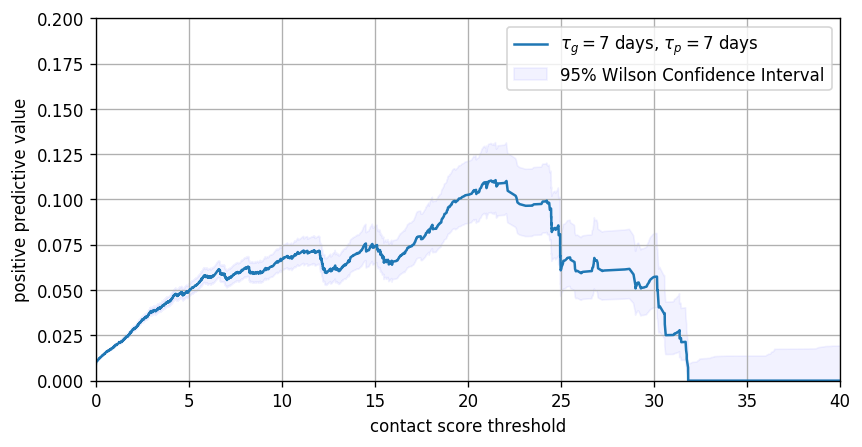

In [17]:
from astropy.stats import binom_conf_interval
plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')

plt.plot(x_list[0]/params[0][0], y_list[0])

ci = binom_conf_interval(positive_edges[0], total_edges[0], confidence_level=0.95, interval='wilson') 
plt.fill_between(x_list[0]/params[0][0], ci[0], ci[1], color='b', alpha=.05)

plt.xlabel('contact score threshold')
plt.ylabel('positive predictive value')
print(params[0][2])
#plt.legend([params[0][2], '95% Wilson Confidence Interval'])
plt.legend([r'$\tau_g = 7$ days, $\tau_p = 7$ days', '95% Wilson Confidence Interval'])
plt.axis([0, 40, 0.0, 0.2])
plt.grid()
plt.show()
#plt.savefig('ppv_ci_g1.pdf', format='pdf')

In [18]:
#params = [(7,7, r'$\tau_g = 7$ days, $\tau_p = 7$ days'), (7,28, r'$\tau_g = 7$ days, $\tau_p = 28$ days'),
#          (28,7,r'$\tau_g = 28$ days, $\tau_p = 7$ days' ), (28,28,r'$\tau_g = 28$ days, $\tau_p = 28$ days')]

params = [(7,7, r'$\tau_g = 7$ days, $\tau_p = 7$ days')]

queries = ["select exposure_score + confidence_score_28_day as score, exposure_score, \
count(*) as total_edges, \
sum(case when in_isolation_2 = 1 and isolation_diff_hours <= "+str(param[1])+"*24 then 1 else 0 end) as positive_edges \
from full_new_df \
where isolation_start_1 > '2021-02-1' and isolation_start_1 < '2021-05-1' \
group by 1;" for param in params] 

x_list, y_list, total_edges, positive_edges = [], [], [], []

for query in queries:
    df_summary = sqldf(query)
    df_summary['cum_positive_edges'] = df_summary['positive_edges'].iloc[::-1].cumsum().iloc[::-1]
    df_summary['cum_total_col'] = df_summary['total_edges'].iloc[::-1].cumsum().iloc[::-1]
    df_summary['positivity'] = df_summary['cum_positive_edges']/df_summary['cum_total_col']
    x_list.append(np.array(df_summary['score']))
    y_list.append(np.array(df_summary['positivity']))
    total_edges.append(np.array(df_summary['cum_total_col']))
    positive_edges.append(np.array(df_summary['cum_positive_edges']))
    
    



$\tau_g = 7$ days, $\tau_p = 7$ days


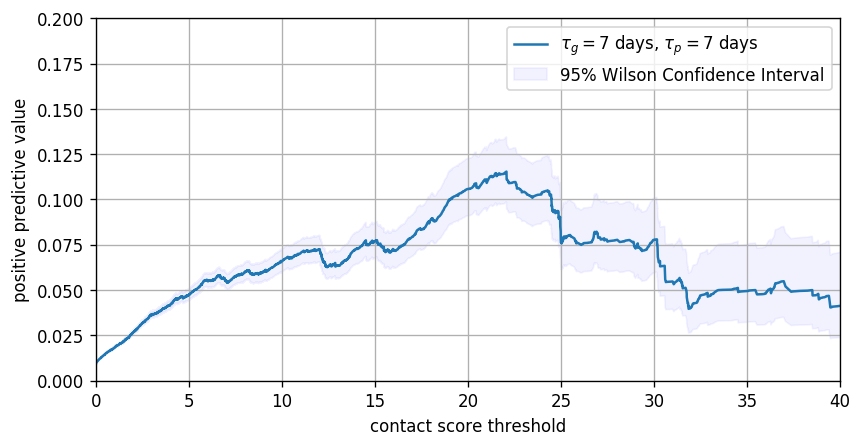

In [19]:

plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')

plt.plot(x_list[0]/params[0][0], y_list[0])

ci = binom_conf_interval(positive_edges[0], total_edges[0], confidence_level=0.95, interval='wilson') 
plt.fill_between(x_list[0]/params[0][0], ci[0], ci[1], color='b', alpha=.05)

plt.xlabel('contact score threshold')
plt.ylabel('positive predictive value')
print(params[0][2])
#plt.legend([params[0][2], '95% Wilson Confidence Interval'])
plt.legend([r'$\tau_g = 7$ days, $\tau_p = 7$ days', '95% Wilson Confidence Interval'])
plt.axis([0, 40, 0.0, 0.2])
plt.grid()
plt.show()
#plt.savefig('ppv_ci_g1.pdf', format='pdf')

In [20]:
gamma = 60

true_pos = 0
predicted_pos = 0

for hour in range(hours):
    scores = score_matrix[:,hour]
    for i in range(subjects):
        hhs = hours_since_epoch(isolation_start_list[i])
        if scores[i] > gamma and (np.isnan(hhs) or hhs >= hour):
             predicted_pos += 1
        if scores[i] > gamma and (np.isnan(hhs) or hhs >= hour) and (~np.isnan(hhs) and hhs <= hour+7*24 and hhs >= hour):
             true_pos += 1

NameError: name 'hours' is not defined

In [21]:
print(true_pos)
print(predicted_pos)

print(true_pos/predicted_pos)

#gamma = 5
#22842
#1450208
#0.01575084401685827

#gamma = 20
# 3.3%

#gamma = 40
# 5.0%

#gamma = 60
# 5.4%

0
0


ZeroDivisionError: division by zero

In [22]:
all_hours = [hours_since_epoch(i) for i in isolation_start_list]
pos_hours = [i for i in all_hours if not np.isnan(i) and i >= 0]
print(len(pos_hours))

333


In [23]:
gamma = 200
true_pos = 0
predicted_pos = 0

for hour in pos_hours:
    scores = score_matrix[:,hour]
    for i in range(subjects):
        hhs = hours_since_epoch(isolation_start_list[i])
        if scores[i] > gamma and (np.isnan(hhs) or hhs >= hour):
             predicted_pos += 1
        if scores[i] > gamma and (np.isnan(hhs) or hhs >= hour) and (~np.isnan(hhs) and hhs <= hour+7*24 and hhs >= hour):
             true_pos += 1
                
               


NameError: name 'subjects' is not defined

In [24]:
print(true_pos/predicted_pos)


ZeroDivisionError: division by zero

In [25]:
positive_hour = [hours_since_epoch(t) for t in isolation_start_list]


#params is tuple with threshold, trailing window cutoff
params = [(4,7),(4,28),(20,7),(20,28)]
results_d = {}
    

for threshold, day_cutoff in params:
    true_pos_list, false_pos_list, false_neg_list, true_neg_list = [],[],[],[]
    for h, col in enumerate(score_matrix.T):
        true_pos_count, false_pos_count, false_neg_count, true_neg_count = 0,0,0,0
        for user, score in enumerate(col):  
            # first case is positives in next t days (not nan and positive_hour in [0, cutoff])
            if not np.isnan(positive_hour[user]) and (positive_hour[user] - h) >= 0 and (positive_hour[user] - h) <= day_cutoff*24: #positive in next t days
                if score >= threshold:
                    true_pos_count +=1
                else:
                    false_neg_count += 1
            # second case is negatives in next t days (is nan or positive_hour > cutoff)])
            elif np.isnan(positive_hour[user]) or ((positive_hour[user] - h) >= day_cutoff*24):  #negative in the next t days, but not those that already tested positive
                if score >= threshold:
                    false_pos_count +=1
                else:
                    true_neg_count += 1                   
        true_pos_list.append(true_pos_count)
        false_pos_list.append(false_pos_count)
        false_neg_list.append(false_neg_count)
        true_neg_list.append(true_neg_count)
        
    results_d[(threshold, day_cutoff)] = {'true_pos': true_pos_list, 'false_pos': false_pos_list,\
                                          'false_neg': false_neg_list, 'true_neg': true_neg_list}

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


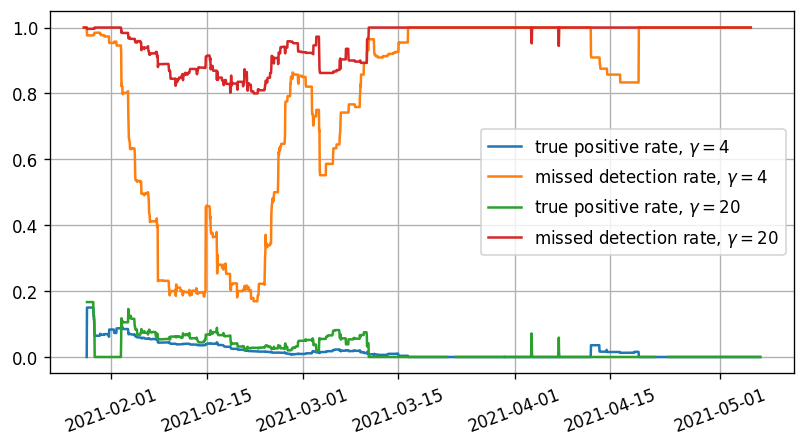

In [26]:
plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')
tt = [dt.timedelta(hours=i)+start_date for i in range(len(results_d[params[0]]['true_pos']))]

true_positive_rate = {}
false_negative_rate = {}

for p in [(4,28),(20,28)]:
    true_positive_rate =\
      np.array(results_d[p]['true_pos'])/(np.array(results_d[p]['true_pos'])+np.array(results_d[p]['false_pos']))
    
    false_negative_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_neg']))
    
    missed_detection_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_pos']))

    plt.plot(tt, true_positive_rate)    
    #plt.plot(tt, false_negative_rate)   
    plt.plot(tt, missed_detection_rate)

plt.legend(['true positive rate, $\gamma = 4$', 'missed detection rate, $\gamma = 4$',\
            'true positive rate, $\gamma = 20$', 'missed detection rate, $\gamma = 20$'] )

plt.xticks(rotation = 20)
#plt.ylim(0, 0.2)

plt.grid()
plt.savefig('tp_md_thres_28_day.pdf', format='pdf')


/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


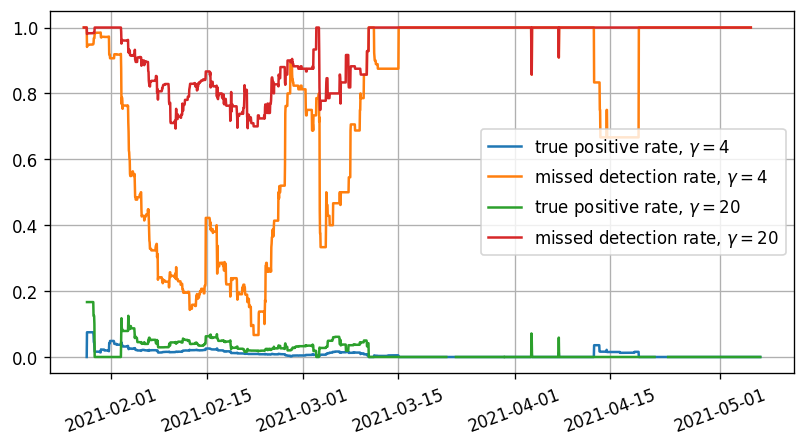

In [27]:
plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')
tt = [dt.timedelta(hours=i)+start_date for i in range(len(results_d[params[0]]['true_pos']))]

true_positive_rate = {}
false_negative_rate = {}

for p in [(4,7),(20,7)]:
    true_positive_rate =\
      np.array(results_d[p]['true_pos'])/(np.array(results_d[p]['true_pos'])+np.array(results_d[p]['false_pos']))
    
    false_negative_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_neg']))
    
    missed_detection_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_pos']))
  
    plt.plot(tt, true_positive_rate)    
    plt.plot(tt, missed_detection_rate)

plt.legend(['true positive rate, $\gamma = 4$', 'missed detection rate, $\gamma = 4$',\
            'true positive rate, $\gamma = 20$', 'missed detection rate, $\gamma = 20$'] )


plt.xticks(rotation = 20)
#plt.ylim(0, 0.2)

plt.grid()
plt.savefig('tp_md_thres_7_day.pdf', format='pdf')


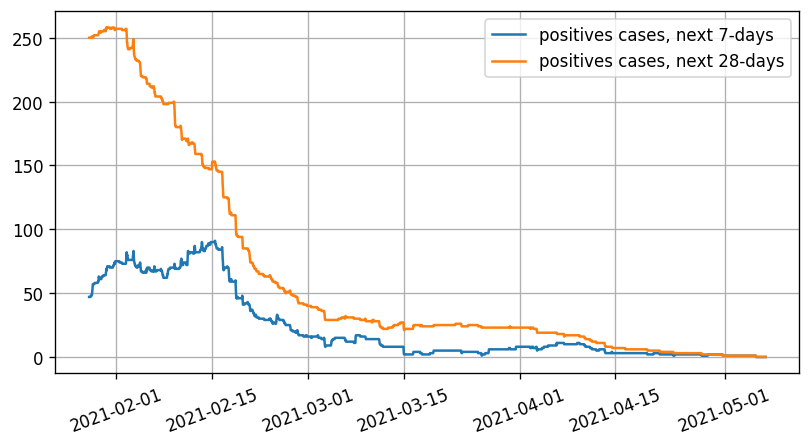

In [28]:
plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')
tt = [dt.timedelta(hours=i)+start_date for i in range(len(results_d[params[0]]['true_pos']))]

for p in [(4,7),(4,28)]:
    positives = np.array(results_d[p]['true_pos'])+np.array(results_d[p]['false_neg'])   
    plt.plot(tt, positives)

plt.legend(['positives cases, next 7-days', 'positives cases, next 28-days'])

plt.xticks(rotation = 20)
plt.grid()
plt.savefig('positive_cases.pdf', format='pdf')

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


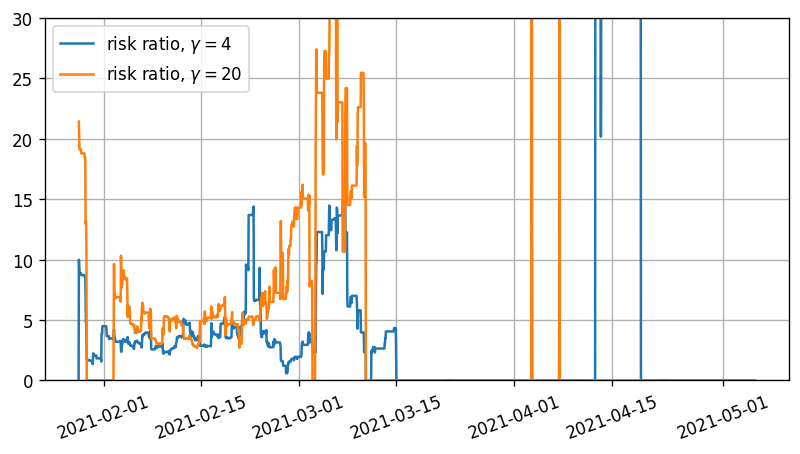

In [29]:
plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')
tt = [dt.timedelta(hours=i)+start_date for i in range(len(results_d[params[0]]['true_pos']))]

true_positive_rate = {}
false_negative_rate = {}

for p in [(4,7),(20,7)]:
    true_positive_rate =\
      np.array(results_d[p]['true_pos'])/(np.array(results_d[p]['true_pos'])+np.array(results_d[p]['false_pos']))
    
    false_negative_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_neg']))
    
    missed_detection_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_pos']))
  
    plt.plot(tt, true_positive_rate/false_negative_rate)   
    #plt.plot(tt, missed_detection_rate)

plt.legend(['risk ratio, $\gamma = 4$', 'risk ratio, $\gamma = 20$'] )

plt.xticks(rotation = 20)
plt.ylim(0, 30)

plt.grid()
plt.savefig('rr_thres_7_day.pdf', format='pdf')

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


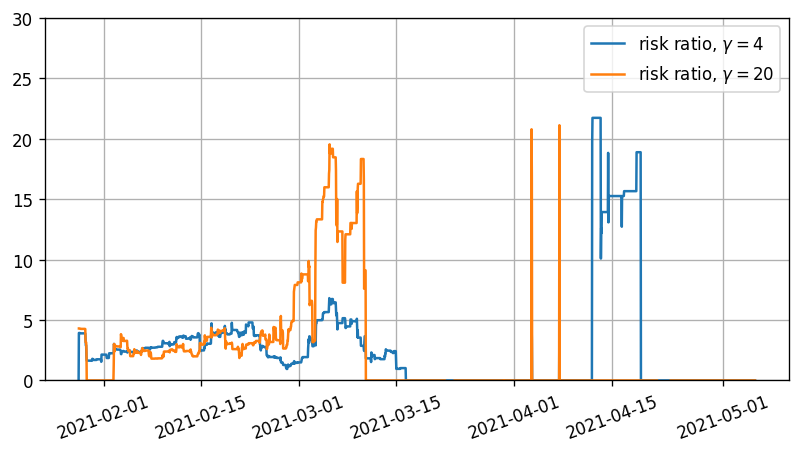

In [30]:
plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')
tt = [dt.timedelta(hours=i)+start_date for i in range(len(results_d[params[0]]['true_pos']))]

true_positive_rate = {}
false_negative_rate = {}

for p in [(4,28),(20,28)]:
    true_positive_rate =\
      np.array(results_d[p]['true_pos'])/(np.array(results_d[p]['true_pos'])+np.array(results_d[p]['false_pos']))
    
    false_negative_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_neg']))
    
    missed_detection_rate =\
      np.array(results_d[p]['false_neg'])/(np.array(results_d[p]['false_neg'])+np.array(results_d[p]['true_pos']))
  
    plt.plot(tt, true_positive_rate/false_negative_rate)   
    #plt.plot(tt, missed_detection_rate)

plt.legend(['risk ratio, $\gamma = 4$', 'risk ratio, $\gamma = 20$'] )

plt.xticks(rotation = 20)
plt.ylim(0, 30)

plt.grid()
plt.savefig('rr_thres_28_day.pdf', format='pdf')

## Create cumulative score traces

<Figure size 960x480 with 0 Axes>

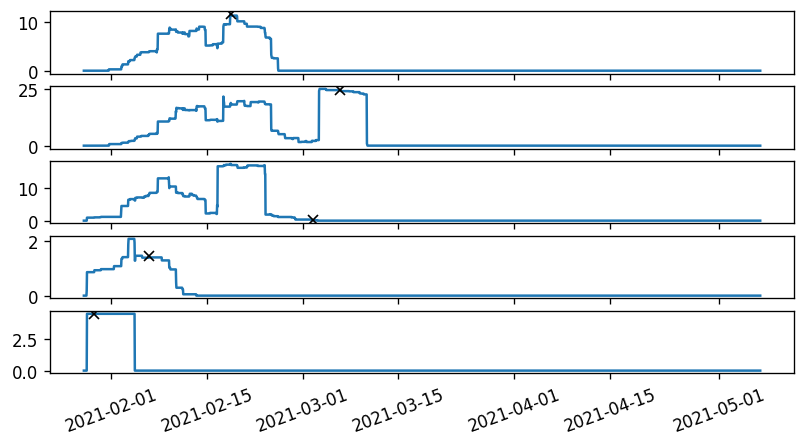

In [36]:
some_positive_ids = np.random.choice(df[df['in_isolation_2']==1]['id_2'].unique(), 5)
some_negative_ids = np.random.choice(df[df['in_isolation_2']==0]['id_2'].unique(), 5)

plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')

fig, axs = plt.subplots(len(some_positive_ids), sharex=True, sharey=False, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')

for i, user in enumerate(some_positive_ids):
    score_vec = np.zeros((score_vec_length))
    for index, row in df[df['id_2']==user].sort_values(by='isolation_start_1').iterrows():
        start_ind = hours_since_epoch(row['isolation_start_1'])
        end_ind = min(hours_since_epoch(row['isolation_start_1'] + dt.timedelta(days=7) ), score_vec_length-1)   
        score_vec[start_ind:end_ind] = score_vec[start_ind:end_ind] + row['confidence_score_7_day']
        isolation_start_2 = row['isolation_start_2']
    axs[i].plot(tt, score_vec)
    axs[i].plot(tt[hours_since_epoch(isolation_start_2)], score_vec[hours_since_epoch(isolation_start_2)],'x', color = 'black')
    
plt.xticks(rotation = 20)
plt.savefig('example_positive_traces.pdf', format='pdf')

<Figure size 960x480 with 0 Axes>

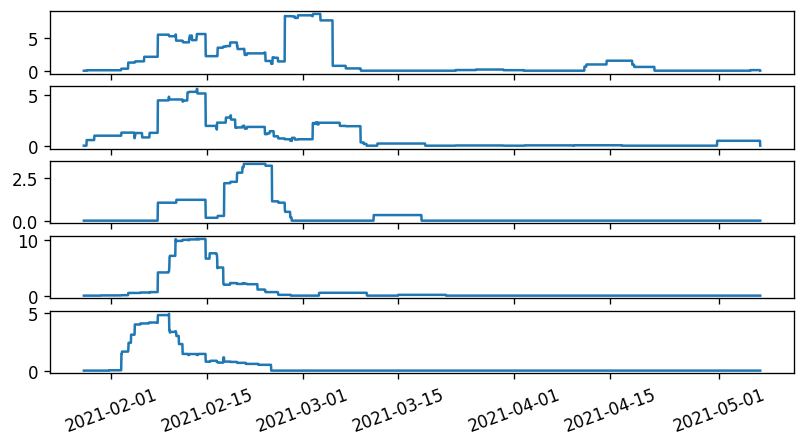

In [37]:
some_positive_ids = np.random.choice(df[df['in_isolation_2']==1]['id_2'].unique(), 5)
some_negative_ids = np.random.choice(df[df['in_isolation_2']==0]['id_2'].unique(), 5)

plt.figure(num=None, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')

fig, axs = plt.subplots(len(some_positive_ids), sharex=True, sharey=False, figsize=(8, 4), dpi=120, facecolor='w', edgecolor='k')

for i, user in enumerate(some_negative_ids):
    score_vec = np.zeros((score_vec_length))
    for index, row in df[df['id_2']==user].sort_values(by='isolation_start_1').iterrows():
        start_ind = hours_since_epoch(row['isolation_start_1'])
        end_ind = min(hours_since_epoch(row['isolation_start_1'] + dt.timedelta(days=7) ), score_vec_length-1)   
        score_vec[start_ind:end_ind] = score_vec[start_ind:end_ind] + row['confidence_score_7_day']
        isolation_start_2 = row['isolation_start_2']
    axs[i].plot(tt, score_vec)
    
plt.xticks(rotation = 20)
plt.savefig('example_negative_traces.pdf', format='pdf')